# Model training and prediction - `s30d`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("..")

In [3]:
os.getcwd()

'/Users/ludvigwarnberggerdin/projects/ttris/pemett'

In [4]:
import numpy as np
import pandas as pd

In [5]:
X_train = pd.read_csv("./data/processed/s30d/X_train.csv", index_col = 0)
y_train = pd.read_csv("./data/processed/s30d/y_train.csv", index_col = 0).s30d
X_test = pd.read_csv("./data/processed/s30d/X_test.csv", index_col = 0)
y_test = pd.read_csv("./data/processed/s30d/y_test.csv", index_col = 0).s30d
tc_train = pd.read_csv("./data/processed/s30d/tc_train.csv", index_col = 0).tc
tc_test = pd.read_csv("./data/processed/s30d/tc_test.csv", index_col = 0).tc

In [6]:
y_train.value_counts() / len(y_train.index) * 100

0.0    94.197074
1.0     5.802926
Name: s30d, dtype: float64

In [7]:
cont_features = ["age", "hr", "sbp", "dbp", "spo2", "rr", "delay"]
cat_features = list(X_train.loc[:, ~X_train.columns.isin(cont_features)].columns)

## Run hyper parameter search

In [8]:
import random
from tqdm.notebook import tqdm
from src.models.train_model import generate_all_combinations

In [9]:
import itertools as it
all_breaks = [(0, ) + x + (np.inf,) for x in it.combinations(np.arange(0.01, 1, 0.01), r=3)]

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [11]:
hyper_parameters = {
    "logisticregression__logisticregression__C": [0.1, 0.2],
    "randomforestclassifier__randomforestclassifier__n_estimators": [100, 200],
    "breaks": all_breaks[:1]
}

In [12]:
numerical_pipeline = Pipeline(steps=[
    ("si", SimpleImputer(strategy="median", add_indicator=True)),
    ("ss", StandardScaler())
])
categorical_pipeline = Pipeline(steps=[
    ("si", SimpleImputer(strategy="most_frequent", add_indicator=True)),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])
transformers = [
    ("cont", numerical_pipeline, cont_features), 
    ("cat", categorical_pipeline, cat_features)]
preprocessor = ColumnTransformer(transformers=transformers)

In [13]:
# lgbm = Pipeline(steps=[("lightgbmclassifier", LGBMClassifier())])
lr = Pipeline(steps = [
    ("pp", preprocessor),
    ("logisticregression", LogisticRegression())
])
rf = Pipeline(steps = [
    ("pp", preprocessor),
    ("randomforestclassifier", RandomForestClassifier())
])
base_clfs = [
    # lgbm,
    lr,
    rf
]

In [14]:
all_hyper_parameters = generate_all_combinations(hyper_parameters)

In [15]:
from src.models.classifiers import StackedGeneralizationClassifier

In [16]:
sgclf = StackedGeneralizationClassifier(
    base_clfs=base_clfs, 
    meta_clf=LogisticRegression(),
    use_probas=True, 
    verbose=False
)
sgclf.cv_outer_loop(
    all_hyper_parameters=all_hyper_parameters,
    X=X_train, 
    y=y_train, 
    refit=True
)

  0%|          | 0/4 [00:00<?, ?it/s]

In [51]:
y_test_prob_con, y_test_prob_cut = sgclf.predict(X_test)

In [52]:
from sklearn.metrics import roc_auc_score

In [53]:
auc_test_con = roc_auc_score(y_score = y_test_prob_con, y_true = y_test)
("Hold-out AUC of ROC, continous model: " + 
str(auc_test_con))

'Hold-out AUC of ROC, continous model: 0.9561327192084612'

In [54]:
auc_test_cut = roc_auc_score(y_score = y_test_prob_cut, y_true = y_test)
("Hold-out AUC of ROC, cut model: " + 
str(auc_test_cut))

'Hold-out AUC of ROC, cut model: 0.9134958205390652'

In [55]:
from src.visualization.visualize import plot_roc, plot_precision_recall

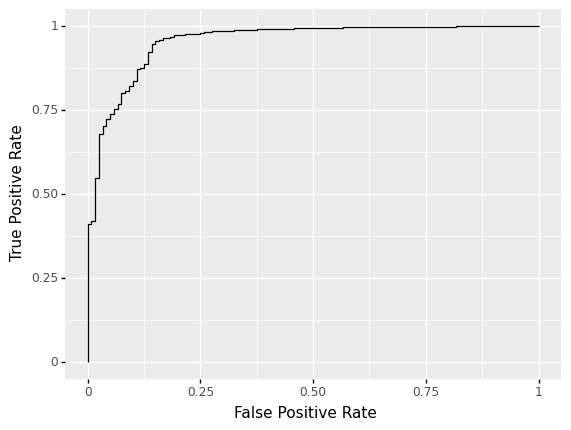

<ggplot: (402044007)>

In [76]:
plot_roc(y_test, y_test_prob_con)

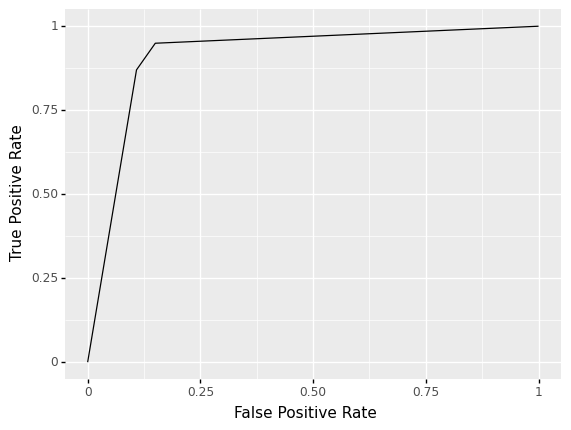

<ggplot: (402015187)>

In [85]:
plot_roc(y_test, y_test_prob_cut)

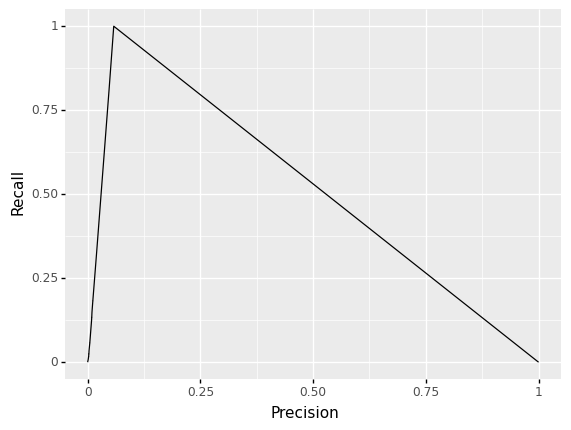

<ggplot: (679592921)>

In [86]:
plot_precision_recall(y_test, y_test_prob_con)

Plot roc curves for each classifier

In [87]:
from src.visualization.visualize import plot_roc_base_clfs

In [88]:
y_test_prob_clfs = sgclf.predict_meta_features(X_test, use_probas = True)
y_test_pred_clfs = sgclf.predict_meta_features(X_test, use_probas = False)

In [89]:
keys = [
    clf.get_params()["steps"][-1][1].__class__.__name__ 
    for clf in sgclf.base_clfs_
]

In [90]:
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    roc_auc_score
)

In [91]:
y_pred_meta_clf = sgclf.predict(X_test, use_probas = False)

In [92]:
y_test_pred_clfs = np.column_stack((y_test_pred_clfs, y_pred_meta_clf))
y_test_prob_clfs = np.column_stack((y_test_prob_clfs, y_test_prob_con))

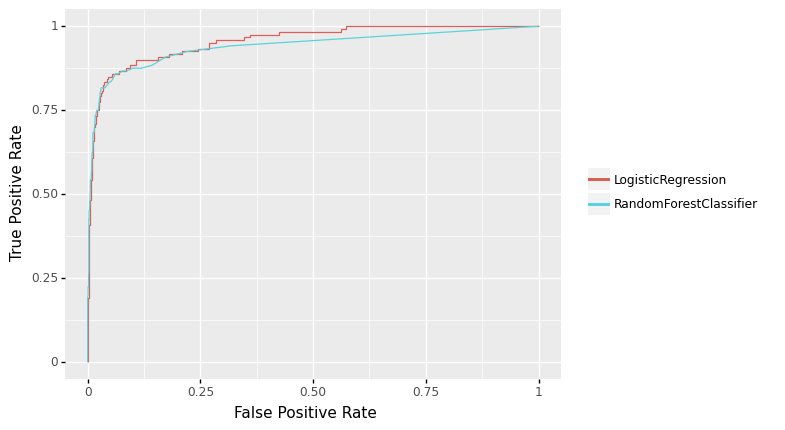

<ggplot: (679641302)>

In [93]:
plot_roc_base_clfs(y_test_prob_clfs, y_test, keys)

In [94]:
from src.models.metrics import bootstrap, compute_performance

In [128]:
stats = bootstrap(
    X=X_train,
    y=y_train, 
    tc=tc_train,
    keys=keys + [sgclf.__class__.__name__],
    base_clfs=base_clfs,
    meta_clf=LogisticRegression(),
    all_hyper_parameters=all_hyper_parameters
)








  0%|                                                                          | 0/5 [00:00<?, ?it/s]During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 
During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 
R[write to console]: 
NRI estimation:

R[write to console]: Point estimates:








100%|██████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]
R[write to console]: 
NRI estimation:

R[write to console]: Point estimates:



  0%|          | 0/4 [00:00<?, ?it/s]
                  Estimate
NRI            0.448074701
NRI+           0.456790123
NRI-          -0.008715423
Pr(Up|Case)    0.506172840
Pr(Down|Case)  0.049382716
Pr(Down|Ctrl)  0.057976506
Pr(Up|Ctrl)    0.066691929
  0%|          | 0/4 [00:00<?, ?it/s]
                  Estimate
NRI            0.498483125
NRI+           0.500000000
NRI-          -0.001516875
Pr(Up|Case)    0.545454545
Pr(Down|Case)  0.045454545
Pr(Down|Ctrl)  0.065225635
Pr(Up|Ctrl)    0.066742510


R[write to console]: 
NRI estimation:

R[write to console]: Point estimates:

R[write to console]: 
NRI estimation:

R[write to console]: Point estimates:



  0%|          | 0/4 [00:00<?, ?it/s]
                  Estimate
NRI            0.470433695
NRI+           0.472727273
NRI-          -0.002293578
Pr(Up|Case)    0.533333333
Pr(Down|Case)  0.060606061
Pr(Down|Ctrl)  0.064220183
Pr(Up|Ctrl)    0.066513761
  0%|          | 0/4 [00:00<?, ?it/s]
                 Estimate
NRI            0.44681786
NRI+           0.46308725
NRI-          -0.01626939
Pr(Up|Case)    0.51006711
Pr(Down|Case)  0.04697987
Pr(Down|Ctrl)  0.05713205
Pr(Up|Ctrl)    0.07340144
  0%|          | 0/4 [00:00<?, ?it/s]
                 Estimate
NRI            0.33471690
NRI+           0.39506173
NRI-          -0.06034483
Pr(Up|Case)    0.42592593
Pr(Down|Case)  0.03086420
Pr(Down|Ctrl)  0.05322339
Pr(Up|Ctrl)    0.11356822


R[write to console]: 
NRI estimation:

R[write to console]: Point estimates:



In [131]:
# Set bootstrap estimates as data frame
stats_df = pd.concat([pd.DataFrame.from_dict(d, orient="index").stack().to_frame() for d in stats], axis = 1)
stats_df.values.sort()
# Set list for simplifying compiling point estimates
y_test_prob_cuts = [None] * len(keys) + [y_test_prob_cut]
# Set point estimates as data frame
point_estimates = pd.DataFrame.from_dict({
    k: compute_performance(
        y_prob=prob, 
        y_pred=pred, 
        y_true=y_test, 
        y_pred_cut=cut, 
        tc=tc_test
    )
    for prob, pred, cut, k in zip(
        y_test_prob_clfs.T, 
        y_test_pred_clfs.T,
        y_test_prob_cuts,
        keys + [sgclf.__class__.__name__]
    )
}, orient = "index").stack().to_frame()
# Compute quantiles for each metric
d1 = (stats_df - point_estimates).apply(np.quantile, q = 0.1, axis = 1)
d2 = (stats_df - point_estimates).apply(np.quantile, q = 0.9, axis = 1)
# Compute upper bounds and lower bounds
ub = round(point_estimates - d1.to_frame(), 2)
lb = round(point_estimates - d2.to_frame(), 2)
# Compile performamance
perf_df = pd.concat([round(point_estimates, 2), lb, ub, ], axis = 1)

NRI estimation:




                 Estimate
NRI            0.36870522
NRI+           0.42500000
NRI-          -0.05629478
Pr(Up|Case)    0.46666667
Pr(Down|Case)  0.04166667
Pr(Down|Ctrl)  0.05834186
Pr(Up|Ctrl)    0.11463664


In [132]:
lb_str = lb.iloc[:, 0].astype(str) 
ub_str = ub.iloc[:, 0].astype(str)
pe_str = round(point_estimates, 2).iloc[:, 0].astype(str)
ci = pe_str + " (" + lb_str + " to " + ub_str +  ")"

In [133]:
perf_df = pd.concat([perf_df, ci.to_frame()], axis = 1)
perf_df.columns = ["point_estimate", "lb", "ub", "ci"]

In [134]:
perf_df

point_estimate    lb    ub  \
LogisticRegression              roc_auc                    0.96  0.95  0.97   
                                prec                       0.88  0.89  0.91   
                                rec                        0.80  0.77  0.82   
RandomForestClassifier          roc_auc                    0.94  0.92  0.96   
                                prec                       0.89  0.89  0.92   
                                rec                        0.79  0.77  0.81   
StackedGeneralizationClassifier roc_auc                    0.96  0.95  0.96   
                                prec                       0.89  0.90  0.92   
                                rec                        0.80  0.77  0.83   
                                auc_model_model            0.04  0.02  0.04   
                                auc_model_tc               0.05  0.04  0.05   
                                nri                        0.37  0.25  0.36   
                                nri_plus                   0.42  0.36  0.43   
                                nri_minus                 -0.06 -0.11 -0.07   

                                                                     ci  
LogisticRegression              roc_auc             0.96 (0.95 to 0.97)  
                                prec                0.88 (0.89 to 0.91)  
                                rec                  0.8 (0.77 to 0.82)  
RandomForestClassifier          roc_auc             0.94 (0.92 to 0.96)  
                                prec                0.89 (0.89 to 0.92)  
                                rec                 0.79 (0.77 to 0.81)  
StackedGeneralizationClassifier roc_auc             0.96 (0.95 to 0.96)  
                                prec                 0.89 (0.9 to 0.92)  
                                rec                  0.8 (0.77 to 0.83)  
                                auc_model_model     0.04 (0.02 to 0.04)  
                                auc_model_tc        0.05 (0.04 to 0.05)  
                                nri                 0.37 (0.25 to 0.36)  
                                nri_plus            0.42 (0.36 to 0.43)  
                                nri_minus        -0.06 (-0.11 to -0.07)